In [87]:
from thesis.optim import filters
from thesis.tools.cli.utilities import load_gaze_data
from thesis.entropy import gradient_histogram, entropy

import os
import math
import numpy as np
import cv2 as cv

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import seaborn as sns

In [116]:
cs = sns.color_palette("viridis", as_cmap=True)

In [2]:
gaze_sets = ('anton', 'maja')
base_path = '/Users/Anton/MEGA/Data/thesis/gaze'
gaze_paths = [os.path.join(base_path, g) for g in gaze_sets]
datasets = load_gaze_data(gaze_paths)

60.0
60.0


In [54]:
img = datasets[0].test_samples[10].image
fs = [
    ("Baseline", lambda x: x, dict()),
    ("Gaussian filter", filters.gaussian_filter, dict(sigma=10)), 
    ("Mean filter", filters.mean_filter, dict(size=11)),
    ("Median filter", filters.median_filter, dict(size=11)),
    ("Bilateral filter", filters.bilateral_filter, dict(sigma_c=80, sigma_s=18)),
    ("Non-local means", filters.non_local_means, dict(h=50)),
    ("Uniform noise", filters.uniform_noise, dict(intensity=100)),
    ("Gaussian noise", filters.gaussian_noise, dict(scale=10, loc=0)),
    ("Cauchy noise", filters.cauchy_noise, dict(scale=10)),
    ("Laplacian noise", filters.laplacian_noise, dict(scale=10)),
    ("Comp", filters.super_filter, dict(sigma_c=80, sigma_s=18, scale=5)),
    ("Comp reverse", filters.super_filter_reverse, dict(sigma_c=80, sigma_s=18, scale=5)),
    ("Salt-and-pepper filter", filters.salt_and_pepper, dict(density=0.3, intensity=100)),
    ("Snow", filters.snow, dict(density=0.3)),
]

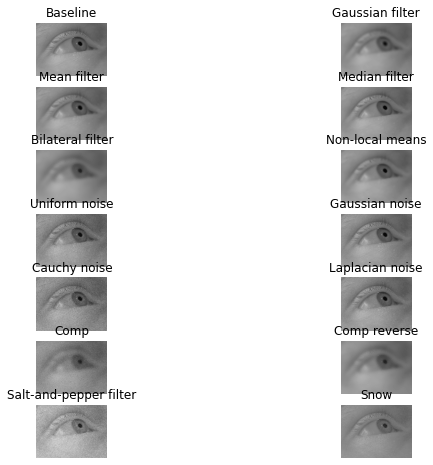

In [123]:
n = len(fs)
cols = 2
rows = math.ceil(n/cols)
fig, ax = plt.subplots(rows, cols, figsize=(10, 8))

for i, (name, f, args) in enumerate(fs):
    y = i // cols
    x = i % cols
    mod = f(img, **args)
    ax[y, x].imshow(mod, cmap='gray', vmin=0, vmax=255)
    ax[y, x].set_title(name)
    ax[y, x].axis('off')

for i in range(rows*cols - n, rows*cols):
    y = i // cols
    x = i % cols
    ax[y, x].axis('off')

In [144]:
def single(x):
    name, f, args = x
    mod = f(img, **args)
    mod = cv.resize(mod, (682, 512))
    hist = gradient_histogram(mod)
    e = entropy(hist)
    return (name, mod, hist, e)

histograms = list(map(single, fs))


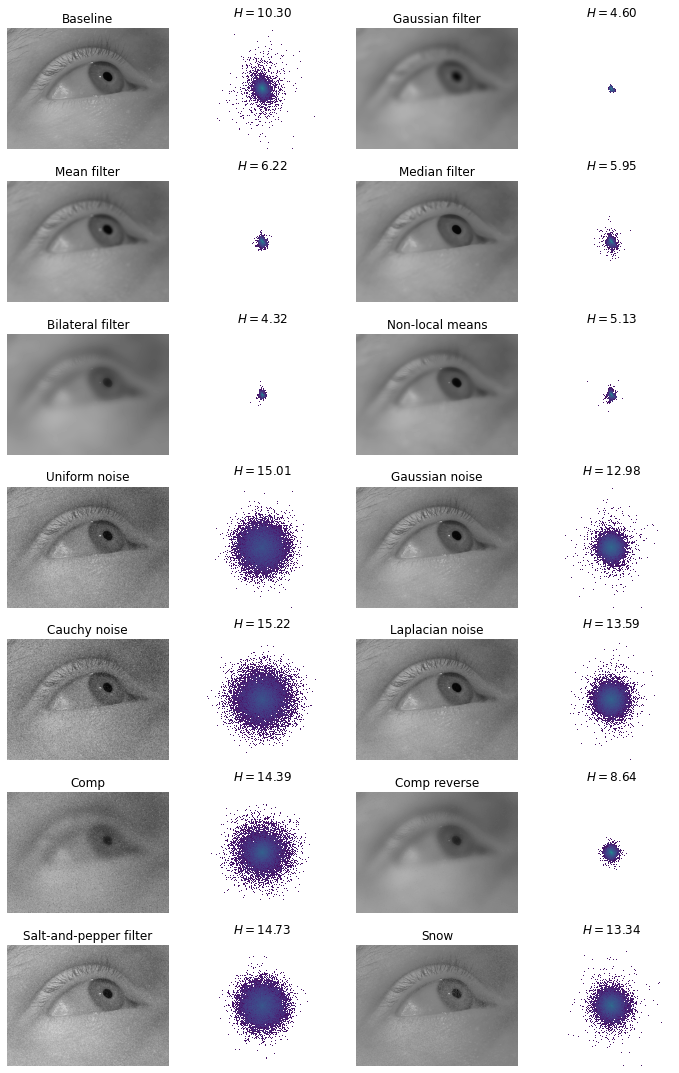

In [147]:
n = len(histograms)
w = 2
cols = 2
rows = math.ceil(n/cols)
fig, ax = plt.subplots(rows, cols*w, figsize=(10, 15))

vmax = max([h[1].max() for h in histograms])
vmin = 10e-7

for i, (name, mod, hist, e) in enumerate(histograms):
    y = i // cols
    x = i % cols

    ax[y, x*w].imshow(mod, cmap='gray', vmin=0, vmax=255)
    res = ax[y, x*w+1].matshow(hist, cmap=cs, norm=LogNorm(vmax=vmax, vmin=vmin))

    ax[y, x*w].set_title(name)
    ax[y, x*w+1].set_title(f'$H = {e:.2f}$')
    
    ax[y, x*w].axis('off')
    ax[y, x*w+1].axis('off')

for i in range(rows*cols - n, rows*cols):
    y = i // cols
    x = i % cols
    ax[y, x*w].axis('off')
    ax[y, x*w+1].axis('off')

#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#fig.colorbar(res, cax=cbar_ax)
fig.tight_layout()
fig.savefig('out/filter_effect.pdf') 
    